# Import Libraries

In [11]:
import pandas as pd
import numpy as np
import scipy as sp

import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier,VotingClassifier


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import roc_auc_score

#from imblearn.over_sampling import SMOTE
import lightgbm
from lightgbm import LGBMClassifier
#import catboost
#from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# Data Size Shrinkage Helper Function

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Read Data

In [24]:
DATA_DIR = '../data'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

In [23]:
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)

client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False)
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv', low_memory=False)

In [5]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


# Data Cleansing

Bad counter_statue and remarque

In [6]:
cate_cols = ['counter_statue','reading_remarque']

In [7]:
for cate_col in cate_cols:
    df1 = invoice_train[cate_col].value_counts().rename_axis(cate_col).to_frame('counts').reset_index()
    df2 = invoice_test[cate_col].value_counts().rename_axis(cate_col).to_frame('counts').reset_index()
    
    # g1 = sns.catplot(x=cate_col,y='counts',kind='bar',data=df1,height = 8, aspect = 1.25)
    # g1.ax.set_title(f'{cate_col} Distribution on Invoice Train Data',fontsize=20)
    # for p in g1.ax.patches:
    #     txt = f'{p.get_height() :,.0f}'
    #     txt_x = p.get_x()
    #     txt_y = p.get_height()
    #     g1.ax.text(txt_x,txt_y,txt, size=13)
    
    # figure1 = g1.fig   
    # figure1.savefig(f'{cate_col} Distribution on Invoice Train Data.jpg',format='jpeg',
    #                dpi=100,
    #                bbox_inches='tight')


    # g2 = sns.catplot(x=cate_col,y='counts',kind='bar',data=df2,height = 8, aspect = 1.25)
    # g2.ax.set_title(f'{cate_col} Distribution on Invoice Test Data',fontsize=20)
    # for p in g2.ax.patches:
    #     txt = f'{p.get_height() :,.0f}'
    #     txt_x = p.get_x()
    #     txt_y = p.get_height()
    #     g2.ax.text(txt_x,txt_y,txt, size=13)
        
    # figure2 = g2.fig   
    # figure2.savefig(f'{cate_col} Distribution on Invoice Test Data.jpg',format='jpeg',
    #                dpi=100,
    #                bbox_inches='tight')

# Wrong Month Number

In [8]:
invoice_train_month = invoice_train['months_number'].value_counts().rename_axis('month_number').to_frame('counts').reset_index()
invoice_test_month = invoice_test['months_number'].value_counts().rename_axis('month_number').to_frame('counts').reset_index()

In [9]:
invoice_train_month.tail()

,month_number,counts
1365,430834,1
1366,179002,1
1367,186166,1
1368,81499,1
1369,463554,1


In [10]:
invoice_test_month.tail()

,month_number,counts
909,11467,1
910,16031,1
911,6198,1
912,2169,1
913,26699,1


In [11]:
month_error_sample = invoice_train[invoice_train['client_id']=='train_Client_100551'].sort_values(by=['counter_type','invoice_date'])

In [12]:
month_error_sample[['client_id', 'invoice_date', 'counter_number','old_index',
       'new_index', 'months_number', 'counter_type']]

,client_id,invoice_date,counter_number,old_index,new_index,months_number,counter_type
20214,train_Client_100551,2009-03-09,1099471,0,495,3311,ELEC
20219,train_Client_100551,2009-11-05,1099471,0,342,495,ELEC
20212,train_Client_100551,2010-06-05,1099471,0,9971,17815,ELEC
20213,train_Client_100551,2010-08-01,1099471,0,3311,9971,ELEC
20211,train_Client_100551,2010-08-30,1099471,0,17815,25778,ELEC
20215,train_Client_100551,2011-03-14,1099471,0,25778,25778,ELEC
20220,train_Client_100551,2011-08-09,545768,0,6828,8,ELEC
20217,train_Client_100551,2012-09-01,545768,6828,17146,4,ELEC
20218,train_Client_100551,2014-06-05,545768,20841,20841,6,ELEC
20216,train_Client_100551,2017-04-27,545768,20842,20842,30,ELEC


In [13]:
idx = month_error_sample['months_number']>100
month_error_sample.loc[idx,['old_index','new_index']] = month_error_sample.loc[idx,['new_index','months_number']].values
month_error_sample.loc[idx,['months_number']] = 4
month_error_sample.loc[month_error_sample['months_number']==0,['months_number']] = 4

In [14]:
month_error_sample[['client_id', 'invoice_date', 'counter_number','old_index',
       'new_index', 'months_number', 'counter_type']]

,client_id,invoice_date,counter_number,old_index,new_index,months_number,counter_type
20214,train_Client_100551,2009-03-09,1099471,495,3311,4,ELEC
20219,train_Client_100551,2009-11-05,1099471,342,495,4,ELEC
20212,train_Client_100551,2010-06-05,1099471,9971,17815,4,ELEC
20213,train_Client_100551,2010-08-01,1099471,3311,9971,4,ELEC
20211,train_Client_100551,2010-08-30,1099471,17815,25778,4,ELEC
20215,train_Client_100551,2011-03-14,1099471,25778,25778,4,ELEC
20220,train_Client_100551,2011-08-09,545768,0,6828,8,ELEC
20217,train_Client_100551,2012-09-01,545768,6828,17146,4,ELEC
20218,train_Client_100551,2014-06-05,545768,20841,20841,6,ELEC
20216,train_Client_100551,2017-04-27,545768,20842,20842,30,ELEC


# Remove clients with bad counter_statue and remarque in train set

In [15]:
#Remove clients with bad counter_statue and remarque in train set
bad_statue_client = ['train_Client_78338','train_Client_13203','train_Client_53725','train_Client_47780','train_Client_30467']
invoice_train = invoice_train[~invoice_train['client_id'].isin(bad_statue_client)]
invoice_train = invoice_train[~((invoice_train['client_id']=='train_Client_79075') & (invoice_train['counter_type']=='GAZ'))].reset_index(drop=True)

client_train = client_train[~client_train['client_id'].isin(bad_statue_client)].reset_index(drop=True)

# Prepare Client Data

In [16]:
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [17]:
def prepare_client(df,Train=True):
        
    df['creation_date'] = pd.to_datetime(df['creation_date'],dayfirst=True)
    df['creation_day'] = df['creation_date'].dt.day
    df['creation_month'] = df['creation_date'].dt.month
    df['creation_year'] = df['creation_date'].dt.year
    df['duration']=(2022 - df['creation_date'].dt.year)*12 - df['creation_date'].dt.month
    
    df['disrict'] = df['disrict'].astype(str).astype('category')
    df['client_catg'] = df['client_catg'].astype(str).astype('category')
    df['region_group'] =  df['region'].apply(lambda x: 1 if x<=100 else 3 if x>=300 else 2)
    df['region'] = df['region'].astype(str).astype('category')
    
    if Train:
        
        col_seq = ['client_id','disrict','client_catg', 'region','region_group','creation_date',
                   'creation_day','creation_month','creation_year','duration','target']
    else:
        col_seq = ['client_id','disrict','client_catg', 'region','region_group','creation_date',
                   'creation_day','creation_month','creation_year','duration']
    df = df[col_seq]
    
    return df

# Get Client Train Data

In [18]:
client_train = prepare_client(client_train,Train=True)

In [19]:
client_train

,client_id,disrict,client_catg,region,region_group,creation_date,creation_day,creation_month,creation_year,duration,target
0,train_Client_0,60,11,101,2,1994-12-31,31,12,1994,324,0.0
1,train_Client_1,69,11,107,2,2002-05-29,29,5,2002,235,0.0
2,train_Client_10,62,11,301,3,1986-03-13,13,3,1986,429,0.0
3,train_Client_100,69,11,105,2,1996-07-11,11,7,1996,305,0.0
4,train_Client_1000,62,11,303,3,2014-10-14,14,10,2014,86,0.0
...,...,...,...,...,...,...,...,...,...,...,...
135483,train_Client_99995,62,11,304,3,2004-07-26,26,7,2004,209,0.0
135484,train_Client_99996,63,11,311,3,2012-10-25,25,10,2012,110,0.0
135485,train_Client_99997,63,11,311,3,2011-11-22,22,11,2011,121,0.0
135486,train_Client_99998,60,11,101,2,1993-12-22,22,12,1993,336,0.0


OneHotEncoding for Categorical Features

In [20]:
ohe = OneHotEncoder(sparse=False,categories='auto')

ohe_columns = []
ohe_cat_cols = ['disrict','client_catg','region']

ohe.fit(client_train[ohe_cat_cols])

OneHotEncoder(sparse=False, sparse_output=False)

In [21]:
for i,c in enumerate(ohe_cat_cols):
    ohe_columns += [f'{c}_{v}' for v in ohe.categories_[i]]
dummy_train = pd.DataFrame(ohe.transform(client_train[ohe_cat_cols]),columns=ohe_columns)

In [22]:
client_train = reduce_mem_usage(pd.concat([client_train.drop(ohe_cat_cols,axis=1),dummy_train],axis=1))
print(client_train.shape)

Mem. usage decreased to 11.50 Mb (70.7% reduction)
(135488, 40)


In [23]:
client_train.head()

,client_id,region_group,creation_date,creation_day,creation_month,creation_year,duration,target,disrict_60,disrict_62,...,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399
0,train_Client_0,2,1994-12-31,31,12,1994,324,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,train_Client_1,2,2002-05-29,29,5,2002,235,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train_Client_10,3,1986-03-13,13,3,1986,429,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train_Client_100,2,1996-07-11,11,7,1996,305,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train_Client_1000,3,2014-10-14,14,10,2014,86,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Get Client Test Data

In [24]:
client_test = prepare_client(client_test,Train=False)

dummy_test = pd.DataFrame(ohe.transform(client_test[ohe_cat_cols]),columns=ohe_columns)

client_test = reduce_mem_usage(pd.concat([client_test.drop(ohe_cat_cols,axis=1),dummy_test],axis=1))
print(client_train.shape)

Mem. usage decreased to  4.82 Mb (70.6% reduction)
(135488, 40)


# Prepare Invoice Data

# Concat Invoice Train and Test

In [25]:
data = pd.concat([invoice_train,invoice_test],axis=0).reset_index(drop=True)
data = reduce_mem_usage(data)
print(data.shape)

Mem. usage decreased to 446.69 Mb (43.0% reduction)
(6416334, 16)


In [26]:
# Adjust Wrong Column Vlues
idx = data['months_number']>100
data.loc[idx,['old_index','new_index']] = data.loc[idx,['new_index','months_number']].values
data.loc[idx,['months_number']] = 4
data.loc[data['months_number']==0,['months_number']] = 4
    
# Adjust Consumption
data['consommation_level_1'] = round(data['consommation_level_1']/data['months_number'],0)
data['consommation_level_2'] = round(data['consommation_level_2']/data['months_number'],0)
data['consommation_level_3'] = round(data['consommation_level_3']/data['months_number'],0)
data['consommation_level_4'] = round(data['consommation_level_4']/data['months_number'],0)

In [27]:
# Adjust Column Type
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

#data['tarif_type'] = data['tarif_type'].astype(str)
data['tarif_type_str'] = data['tarif_type'].astype(str)

#data['counter_number'] = data['counter_number'].astype(str)

data['counter_statue'] = data['counter_statue'].astype(str)
data['counter_statue_str'] = data['counter_statue']

#data['counter_code'] = data['counter_code'].astype(str)
data['counter_code_str'] = data['counter_code'].astype(str)

#data['reading_remarque'] = data['reading_remarque'].astype(str)
data['reading_remarque_str'] = data['reading_remarque'].astype(str)

In [28]:
# Helper Column for Counter Type Split
data['GAZ']='GAZ'
data['ELEC']='ELEC'

# Feature Engineering

# Add Time Features

In [29]:
data['invoice_date_day'] = data['invoice_date'].dt.day
data['invoice_date_month'] = data['invoice_date'].dt.month
data['invoice_date_year'] = data['invoice_date'].dt.year

# Add Diff Features

In [30]:
data['index_diff'] = data['new_index']-data['old_index']

In [31]:
data['invoice_diff']=data.sort_values(by=['client_id','counter_type','invoice_date']).groupby(['client_id','counter_type'])['invoice_date'].diff().dt.days
data['con_1_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_1'].diff()
data['con_2_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_2'].diff()
data['con_3_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_3'].diff()
data['con_4_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_4'].diff()
data['index_diff_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['index_diff'].diff()

# Interaction Columns

In [32]:
data['number_plus_code'] = data['counter_number'] + data['counter_code']
data['number_minus_code'] = data['counter_number'] - data['counter_code']
data['number_multi_code'] = data['counter_number'] * data['counter_code']
data['number_div_code'] = data['counter_number'] / data['counter_code']

# Feature Aggregation

In [33]:
# Create base dataframe for aggregation
base = data[['client_id','ELEC','GAZ']].drop_duplicates()
# Create helper columns for quick mapping
base['ELEC'] = list(zip(base['client_id'],base['ELEC']))
base['GAZ'] = list(zip(base['client_id'],base['GAZ']))

In [34]:
base.shape

(193557, 3)

In [35]:
num_feature = ['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4',
               'old_index','new_index','number_plus_code','number_minus_code','number_multi_code','number_div_code']

num_diff_feature = ['invoice_diff','con_1_diff','con_2_diff','con_3_diff','con_4_diff','index_diff_diff']

cate_feature = ['tarif_type', 'counter_number','counter_statue', 'counter_code', 
                'reading_remarque','counter_coefficient',
                'invoice_date_day','invoice_date_month','invoice_date_year']

cate_freq_feature = ['tarif_type_str','counter_statue_str', 'counter_code_str','reading_remarque_str']


# Label Encode Categorical Features

In [36]:
le = LabelEncoder()
for feature in cate_feature:
    le.fit(data[feature])
    data[feature] = le.transform(data[feature])

# Numerical Feature aggregation

In [37]:
#num_feature = ['consommation_level_1']

In [38]:
for feature in (num_feature):
    mean_dict = dict(data.groupby(['client_id','counter_type'])[feature].mean())
    min_dict = dict(data.groupby(['client_id','counter_type'])[feature].min())
    max_dict = dict(data.groupby(['client_id','counter_type'])[feature].max())
    std_dict = dict(data.groupby(['client_id','counter_type'])[feature].std())
    sum_dict = dict(data.groupby(['client_id','counter_type'])[feature].sum())
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_mean_{type_}'] = base[f'{type_}'].map(mean_dict)
        base[f'{feature}_min_{type_}'] = base[f'{type_}'].map(min_dict)
        base[f'{feature}_max_{type_}'] = base[f'{type_}'].map(max_dict)
        base[f'{feature}_std_{type_}'] = base[f'{type_}'].map(std_dict)
        base[f'{feature}_sum_{type_}'] = base[f'{type_}'].map(sum_dict)
               
        base[f'{feature}_range_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_min_{type_}']
        base[f'{feature}_max_mean_diff_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_mean_{type_}']

# Numerical Diff Feature aggregation

In [39]:
for feature in num_diff_feature:
    mean_dict = dict(data.groupby(['client_id','counter_type'])[feature].mean())
    min_dict = dict(data.groupby(['client_id','counter_type'])[feature].min())
    max_dict = dict(data.groupby(['client_id','counter_type'])[feature].max())
    std_dict = dict(data.groupby(['client_id','counter_type'])[feature].std())
    sum_dict = dict(data.groupby(['client_id','counter_type'])[feature].sum())
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_mean_{type_}'] = base[f'{type_}'].map(mean_dict)
        base[f'{feature}_min_{type_}'] = base[f'{type_}'].map(min_dict)
        base[f'{feature}_max_{type_}'] = base[f'{type_}'].map(max_dict)
        base[f'{feature}_std_{type_}'] = base[f'{type_}'].map(std_dict)
        base[f'{feature}_sum_{type_}'] = base[f'{type_}'].map(sum_dict)
               
        base[f'{feature}_range_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_min_{type_}']
        base[f'{feature}_max_mean_diff_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_mean_{type_}']

# Categorical Feature aggregation

In [40]:
for feature in cate_feature:
    nunique_dict = dict(data.groupby(['client_id','counter_type'])[feature].nunique())
    mode_dict = dict(data.groupby(['client_id','counter_type'])[feature].agg(lambda x: pd.Series.mode(x)[0]))
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_nunique_{type_}'] = base[f'{type_}'].map(nunique_dict)
        base[f'{feature}_mode_{type_}'] = base[f'{type_}'].map(mode_dict)

# Categorical Feature Frequency Aggregation

In [41]:
# 1. Tarif_type
tarif_group = data.groupby(['client_id','counter_type','tarif_type_str']).agg(Percent=('tarif_type_str', 'count'))
tarif_group = (tarif_group / tarif_group.groupby(level=[0, 1]).transform("sum")).reset_index()

tarif_group=tarif_group.set_index(['client_id','counter_type','tarif_type_str']).stack().unstack([2,1])
tarif_group.columns = tarif_group.columns.map('_'.join)
tarif_group.sort_index(axis=1,inplace=True)
tarif_group=tarif_group.add_prefix('Tarif_Type_').reset_index().drop(columns=['level_1']).fillna(0)

#  2. Counter_statue
statue_group = data.groupby(['client_id','counter_type','counter_statue_str']).agg(Percent=('counter_statue_str', 'count'))
statue_group = (statue_group / statue_group.groupby(level=[0, 1]).transform("sum")).reset_index()

statue_group=statue_group.set_index(['client_id','counter_type','counter_statue_str']).stack().unstack([2,1])
statue_group.columns = statue_group.columns.map('_'.join)
statue_group.sort_index(axis=1,inplace=True)
statue_group=statue_group.add_prefix('Statue_').reset_index().drop(columns=['level_1']).fillna(0)

#  3.  Counter_code  
code_group = data.groupby(['client_id','counter_type','counter_code_str']).agg(Percent=('counter_code_str', 'count'))
code_group = (code_group / code_group.groupby(level=[0, 1]).transform("sum")).reset_index()

code_group=code_group.set_index(['client_id','counter_type','counter_code_str']).stack().unstack([2,1])
code_group.columns = code_group.columns.map('_'.join)
code_group.sort_index(axis=1,inplace=True)
code_group=code_group.add_prefix('Code_').reset_index().drop(columns=['level_1']).fillna(0)

#  4.  Reading_remarque 
rem_group = data.groupby(['client_id','counter_type','reading_remarque_str']).agg(Percent=('reading_remarque_str', 'count'))
rem_group = (rem_group / rem_group.groupby(level=[0, 1]).transform("sum")).reset_index()

rem_group=rem_group.set_index(['client_id','counter_type','reading_remarque_str']).stack().unstack([2,1])
rem_group.columns = rem_group.columns.map('_'.join)
rem_group.sort_index(axis=1,inplace=True)
rem_group=rem_group.add_prefix('Rem_').reset_index().drop(columns=['level_1']).fillna(0)

# Extra Features

In [42]:
#  1. Invoice_Count
count_group=data.groupby(['client_id','counter_type']).size().reset_index(name='Invoice_Count')
count_group=count_group.set_index(['client_id','counter_type']).stack().unstack([2,1])
count_group.columns = count_group.columns.map('_'.join)
count_group = count_group.reset_index().fillna(0)

#  2. Invoice Date Range
invoice_range_group=data.groupby(['client_id','counter_type']).agg(first_date=('invoice_date', np.min),
                                                               last_date=('invoice_date', np.max)).reset_index()

invoice_range_group['date_range'] = (invoice_range_group['last_date']-invoice_range_group['first_date']).dt.days

invoice_range_group=invoice_range_group.set_index(['client_id','counter_type']).stack().unstack([2,1])
invoice_range_group.columns = invoice_range_group.columns.map('_'.join)
invoice_range_group = invoice_range_group.reset_index()

In [64]:
index_diff =data.copy()
index_diff['consumption_diff'] = index_diff[['consommation_level_1', 'consommation_level_2','consommation_level_3','consommation_level_4']].sum(axis=1) 
-( index_diff['new_index'] - index_diff['old_index']) 
aggs = {}
aggs['consumption_diff'] = ['sum','mean']
aggs['invoice_date'] = ['min','max','count']
aggs['consommation_level_1'] = ['sum']
aggs['consommation_level_2'] = ['sum']
aggs['consommation_level_3'] = ['sum']
aggs['consommation_level_4'] = ['sum']
invoice_agg = index_diff.groupby(['client_id']).agg(aggs)
invoice_agg.columns = ['_'.join(col).strip() for col in invoice_agg.columns.values]



#add two features Frequency of the invoice;the energy consumption on average per day
invoice_agg[['invoice_date_max','invoice_date_min']] = invoice_agg[['invoice_date_max','invoice_date_min']].apply(pd.to_datetime)
invoice_agg['tenure_days']= (invoice_agg['invoice_date_max'] - invoice_agg['invoice_date_min']).dt.days

invoice_agg['invoice_freq'] = invoice_agg['tenure_days']/invoice_agg['invoice_date_count']
invoice_agg['consumption_sum'] = invoice_agg[['consommation_level_1_sum', 'consommation_level_2_sum','consommation_level_3_sum']].sum(axis=1)

#if tenure days is 0, keep it as it is, else divide by tenure days
invoice_agg['daily_consumption'] = invoice_agg.apply(lambda x: x['consumption_sum'] if x['tenure_days'] == 0 else x['consumption_sum']/x['tenure_days'], axis=1)

columns_to_drop = ['invoice_date_min', 'invoice_date_max', 'invoice_date_count', 'consommation_level_1_sum', 'consommation_level_2_sum', 'consommation_level_3_sum', 
'consommation_level_4_sum', 'consumption_sum']

invoice_agg.drop(columns_to_drop, axis=1, inplace=True)
# Reset the index of the aggregated dataframe
invoice_agg.reset_index(inplace=True)

In [65]:
invoice_agg

,client_id,consumption_diff_sum,consumption_diff_mean,tenure_days,invoice_freq,daily_consumption
0,test_Client_0,4133.0,111.702703,4967,134.243243,0.832092
1,test_Client_1,12732.0,578.727273,3744,170.181818,2.539263
2,test_Client_10,11229.0,151.743243,5022,67.864865,2.235364
3,test_Client_100,2566.0,64.150000,2486,62.150000,1.032180
4,test_Client_1000,8349.0,157.528302,5137,96.924528,1.625268
...,...,...,...,...,...,...
193552,train_Client_99995,35.0,0.492958,5099,71.816901,0.006864
193553,train_Client_99996,1931.0,47.097561,2307,56.268293,0.837018
193554,train_Client_99997,2323.0,64.527778,2821,78.361111,0.823467
193555,train_Client_99998,119.0,59.500000,122,61.000000,0.975410


# Combine All Features

In [66]:
df_list = [base, count_group, invoice_range_group, tarif_group,statue_group,code_group, rem_group,invoice_agg]
final = df_list[0]
for df_ in df_list[1:]:
    final = final.merge(df_, how='left',on='client_id')

final.drop(columns=['ELEC','GAZ'],inplace=True)
final = reduce_mem_usage(final)

Mem. usage decreased to 186.81 Mb (64.0% reduction)


In [67]:
final.head()

,client_id,consommation_level_1_mean_ELEC,consommation_level_1_min_ELEC,consommation_level_1_max_ELEC,consommation_level_1_std_ELEC,consommation_level_1_sum_ELEC,consommation_level_1_range_ELEC,consommation_level_1_max_mean_diff_ELEC,consommation_level_1_mean_GAZ,consommation_level_1_min_GAZ,...,Rem_7_GAZ,Rem_8_ELEC,Rem_8_GAZ,Rem_9_ELEC,Rem_9_GAZ,consumption_diff_sum,consumption_diff_mean,tenure_days,invoice_freq,daily_consumption
0,train_Client_0,79.875000,19.0,300.0,76.312500,2796.0,281.0,220.125000,NaN,NaN,...,0.0,0.228516,0.0,0.171387,0.0,2888.0,82.514282,4901,140.0000,0.589355
1,train_Client_1,129.375000,82.0,194.0,24.000000,4789.0,112.0,64.562500,NaN,NaN,...,0.0,0.162109,0.0,0.297363,0.0,4789.0,129.432434,4913,132.7500,0.974609
2,train_Client_10,123.812500,47.0,200.0,36.906250,2229.0,153.0,76.187500,NaN,NaN,...,0.0,0.277832,0.0,0.166626,0.0,2286.0,127.000000,4921,273.5000,0.464600
3,train_Client_100,0.300049,0.0,4.0,0.978516,6.0,4.0,3.699219,NaN,NaN,...,0.0,0.000000,0.0,0.049988,0.0,6.0,0.300000,2664,133.2500,0.002253
4,train_Client_1000,173.125000,62.0,200.0,43.343750,2424.0,138.0,26.859375,NaN,NaN,...,0.0,0.142822,0.0,0.856934,0.0,3331.0,237.928574,1585,113.1875,2.019531


# Split Train and Test

In [68]:
train_invoice_agg = final[final['client_id'].str.contains('train')].reset_index(drop=True)

In [69]:
train_invoice_agg.shape

(135488, 351)

In [70]:
test_invoice_agg = final[final['client_id'].str.contains('test')].reset_index(drop=True)

In [71]:
test_invoice_agg.shape

(58069, 351)

# Merge Invoice and Client

In [72]:
def merge_client_invoice(client,invoice_agg):
    df = client.merge(invoice_agg,how='inner',on='client_id')
    
    df['date_range_ELEC'] = df['date_range_ELEC'].astype('float64')
    df['date_range_GAZ'] = df['date_range_GAZ'].astype('float64')
    df['first_date_ELEC'] = pd.to_datetime(df['first_date_ELEC'])
#   df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['last_date_ELEC'] = pd.to_datetime(df['last_date_ELEC'])
    df['first_date_GAZ'] = pd.to_datetime(df['first_date_GAZ'])
    df['last_date_GAZ'] = pd.to_datetime(df['last_date_GAZ'])
    
    df['first_invoice_gap_ELEC']  = (df['first_date_ELEC']-df['creation_date']).dt.days
    df['last_invoice_gap_ELEC']  = (df['last_date_ELEC']-df['creation_date']).dt.days
    df['first_invoice_gap_GAZ']  = (df['first_date_GAZ']-df['creation_date']).dt.days
    df['last_invoice_gap_GAZ']  = (df['last_date_GAZ']-df['creation_date']).dt.days
    df.drop(columns = ['client_id','first_date_ELEC','last_date_ELEC','first_date_GAZ','last_date_GAZ','creation_date'],inplace=True)
    print(df.shape)
    return df

In [73]:
test_df = merge_client_invoice(client_test,test_invoice_agg)

(58069, 387)


In [74]:
train_df = merge_client_invoice(client_train,train_invoice_agg)

(135488, 388)


In [75]:
train_df.tail()

,region_group,creation_day,creation_month,creation_year,duration,target,disrict_60,disrict_62,disrict_63,disrict_69,...,Rem_9_GAZ,consumption_diff_sum,consumption_diff_mean,tenure_days,invoice_freq,daily_consumption,first_invoice_gap_ELEC,last_invoice_gap_ELEC,first_invoice_gap_GAZ,last_invoice_gap_GAZ
135483,3,26,7,2004,209,0.0,0.0,1.0,0.0,0.0,...,0.000000,35.0,0.492958,5099,71.81250,0.006863,349.0,5448.0,1310.0,5448.0
135484,3,25,10,2012,110,0.0,0.0,0.0,1.0,0.0,...,0.666504,1931.0,47.097561,2307,56.28125,0.836914,120.0,2427.0,120.0,2427.0
135485,3,22,11,2011,121,0.0,0.0,0.0,1.0,0.0,...,1.000000,2323.0,64.527779,2821,78.37500,0.823242,85.0,2906.0,85.0,1807.0
135486,2,22,12,1993,336,0.0,1.0,0.0,0.0,0.0,...,0.000000,119.0,59.500000,122,61.00000,0.975586,4258.0,4380.0,NaN,NaN
135487,2,18,2,1986,430,0.0,1.0,0.0,0.0,0.0,...,0.000000,345.0,115.000000,244,81.31250,1.414062,3628.0,3872.0,NaN,NaN


# Train Baseline Models

In [76]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [77]:
# train_df.to_csv('train_df.csv',index=False)
# test_df.to_csv('test_df.csv',index=False)

In [18]:
file_path = 'C:\\Users\\carni\\Downloads\\train_df.csv'  # Replace with your CSV file path
train_df = pd.read_csv(file_path)

In [19]:
file_path = 'C:\\Users\\carni\\Downloads\\test_df.csv' 
test_df= pd.read_csv(file_path)

In [20]:
target=train_df['target']
train_df.drop('target',axis=1,inplace=True)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
# import optuna

## LGBM

In [80]:
light_GBM =Pipeline([

    ('model', LGBMClassifier(boosting_type='gbdt',class_weight='balanced',))
])
light_GBM.fit(train_df, target)

[LightGBM] [Info] Number of positive: 7566, number of negative: 127922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56575
[LightGBM] [Info] Number of data points in the train set: 135488, number of used features: 336
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('model', LGBMClassifier(class_weight='balanced'))])

In [81]:
fraud_predictions = light_GBM.predict_proba(test_df)


fraud_predictions = fraud_predictions[:, 1]

## rf tuning

In [85]:


def objective(trial,X,y):
    # Define the hyperparameters to be optimized
    max_samples = trial.suggest_float("max_samples", 0.5, 0.7)  # Fraction of samples to be used for each tree
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100)

    # Create the pipeline with the suggested parameters
    clf_rf = Pipeline([

        # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
        ('model', RandomForestClassifier(n_estimators=1000,
                                             max_samples=max_samples, 
                                             min_samples_split=min_samples_split, 
                                             class_weight= 'balanced',
                                             n_jobs=4,
                                             random_state=42))
    ])
    
    # # Fit the model
    # clf_rf.fit(agg_train, target)
    cv_scores = cross_val_score(clf_rf, X, y, cv=5, n_jobs=3, scoring="roc_auc")
    score = np.mean(cv_scores)
    # scorestd = cv_scores.std()
    return score  # Replace with appropriate metric

# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(lambda trial: objective(trial, train_df, target), n_trials=15,  gc_after_trial=True)

# Print the optimal parameters
print(study.best_params)

#20 mins a run

[I 2023-12-13 22:51:15,952] A new study created in memory with name: no-name-fedff801-cad2-4869-b5c1-42e5905344d3
[I 2023-12-13 23:08:52,049] Trial 0 finished with value: 0.8825006368217286 and parameters: {'max_samples': 0.5526782624676314, 'min_samples_split': 100}. Best is trial 0 with value: 0.8825006368217286.


In [ ]:
study.best_params

# 'max_samples': 0.6619791965094244, 'min_samples_split': 5

In [14]:
clf_rf = Pipeline([

        # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
        ('model', RandomForestClassifier(n_estimators=1000,
                                            #  **study.best_params,
                                            max_samples= 0.6619791965094244, min_samples_split= 5,
                                            class_weight='balanced',
                                             n_jobs=-1,
                                             random_state=42))
    ])

# cv_scores = cross_val_score(clf_rf, train_df, target, cv=5, n_jobs=-1, scoring="roc_auc")
clf_rf.fit(train_df, target)
fraud_predictions = clf_rf.predict_proba(test_df)


fraud_predictions = fraud_predictions[:, 1]


In [13]:
# cv_scores
# array([0.88350331, 0.89065189, 0.88998603, 0.8803551 , 0.89022424])

array([0.88350331, 0.89065189, 0.88998603, 0.8803551 , 0.89022424])

In [31]:
import numpy as np
scores = [0.88350331, 0.89065189, 0.88998603, 0.8803551, 0.89022424]
mean_score = np.mean(scores)
mean_score


0.8869441140000001

### CatBoost

In [9]:
def objective(trial,X,y):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10), 
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'max_bin': trial.suggest_int('max_bin', 100, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 5), 
        # Fixed parameters
        'iterations': 1000,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'auto_class_weights': 'Balanced',
        # 'thread_count':4,
        'task_type': 'GPU',
        
    }
    cat_boost = Pipeline([
            
            # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
            ('model', CatBoostClassifier(**param))
        ])

    cv_scores = cross_val_score(cat_boost, X, y, cv=5, n_jobs=-1, scoring="roc_auc")
    score = np.mean(cv_scores)
    return score




# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(lambda trial: objective(trial, train_df, target), n_trials=75,  gc_after_trial=True)

# Print the optimal parameters
print(study.best_params)

[I 2023-12-14 15:05:38,737] A new study created in memory with name: no-name-e22dda34-ddbb-41d0-950c-b653ef5b0dde
[I 2023-12-14 15:25:29,411] Trial 0 finished with value: 0.8749698421283651 and parameters: {'learning_rate': 0.24844549499850485, 'depth': 10, 'min_data_in_leaf': 15, 'max_bin': 163, 'l2_leaf_reg': 3.0628281053426942}. Best is trial 0 with value: 0.8749698421283651.
[I 2023-12-14 15:30:49,029] Trial 1 finished with value: 0.8842300476282899 and parameters: {'learning_rate': 0.23142459996815903, 'depth': 4, 'min_data_in_leaf': 11, 'max_bin': 289, 'l2_leaf_reg': 3.3791658539648033}. Best is trial 1 with value: 0.8842300476282899.
[I 2023-12-14 15:36:35,402] Trial 2 finished with value: 0.8792366954782354 and parameters: {'learning_rate': 0.23353378234000977, 'depth': 5, 'min_data_in_leaf': 4, 'max_bin': 195, 'l2_leaf_reg': 4.434218891312394}. Best is trial 1 with value: 0.8842300476282899.
[I 2023-12-14 15:56:43,636] Trial 3 finished with value: 0.874933255457942 and paramet

{'learning_rate': 0.03780741495759566, 'depth': 5, 'min_data_in_leaf': 50, 'max_bin': 202, 'l2_leaf_reg': 3.437958066244254}


In [ ]:
study.best_params
#best cv score is 0.8363991169354101
#best cv score is 0.8970436813547202

{'learning_rate': 0.03780741495759566,
 'depth': 5,
 'min_data_in_leaf': 50,
 'max_bin': 202,
 'l2_leaf_reg': 3.437958066244254}

In [27]:
# to test cvscore
param = {
   # Example fixed value
    # You can add other CatBoost specific parameters here
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced',
    'iterations': 1000,
    'thread_count':4,
    # 'task_type': 'GPU',
}

cat_boost = Pipeline([
        # ('preprocessing', preprocessing),
        # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
        ('model', CatBoostClassifier(**param))
    ])


cv_scores = cross_val_score(cat_boost, train_df, target, cv=5, n_jobs=-1, scoring="roc_auc")

print(cv_scores.mean())

0.8916516173021621


In [21]:
# Example parameter values
param = {
    'learning_rate': 0.03780741495759566,
    'depth': 5,
    'min_data_in_leaf': 50,
    'max_bin': 202,
    'l2_leaf_reg': 3.437958066244254,   # Example fixed value
    # You can add other CatBoost specific parameters here
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced',
    'iterations': 1000,
    'thread_count':4,
    # 'task_type': 'GPU',
}


# Example of using these parameters in CatBoostClassifier




cat_boost = Pipeline([
        # ('preprocessing', preprocessing),
        # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
        ('model', CatBoostClassifier(**param))
    ])


# cv_scores = cross_val_score(cat_boost, train_df, target, cv=5, n_jobs=-1, scoring="roc_auc")

cat_boost.fit(train_df, target)


0:	total: 105ms	remaining: 1m 44s
1:	total: 190ms	remaining: 1m 34s
2:	total: 269ms	remaining: 1m 29s
3:	total: 354ms	remaining: 1m 28s
4:	total: 440ms	remaining: 1m 27s
5:	total: 521ms	remaining: 1m 26s
6:	total: 617ms	remaining: 1m 27s
7:	total: 699ms	remaining: 1m 26s
8:	total: 780ms	remaining: 1m 25s
9:	total: 866ms	remaining: 1m 25s
10:	total: 954ms	remaining: 1m 25s
11:	total: 1.05s	remaining: 1m 26s
12:	total: 1.13s	remaining: 1m 25s
13:	total: 1.21s	remaining: 1m 25s
14:	total: 1.3s	remaining: 1m 25s
15:	total: 1.39s	remaining: 1m 25s
16:	total: 1.46s	remaining: 1m 24s
17:	total: 1.55s	remaining: 1m 24s
18:	total: 1.65s	remaining: 1m 25s
19:	total: 1.74s	remaining: 1m 25s
20:	total: 1.82s	remaining: 1m 25s
21:	total: 1.9s	remaining: 1m 24s
22:	total: 1.99s	remaining: 1m 24s
23:	total: 2.07s	remaining: 1m 24s
24:	total: 2.16s	remaining: 1m 24s
25:	total: 2.29s	remaining: 1m 25s
26:	total: 2.44s	remaining: 1m 27s
27:	total: 2.54s	remaining: 1m 28s
28:	total: 2.63s	remaining: 1m 2

Pipeline(steps=[('model',
                 <catboost.core.CatBoostClassifier object at 0x00000295A82D5DD0>)])

In [22]:
fraud_predictions = cat_boost.predict_proba(test_df)


fraud_predictions = fraud_predictions[:, 1]

In [7]:
cv_scores
# 6m 44.1

array([0.88415593, 0.88762578, 0.89306668, 0.88031252, 0.88748123])

## LGBM

In [26]:
lgbm_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt', 
    'metric': 'auc',
    "n_estimators": 500,
    'is_unbalance': True,
    'num_threads':-1,
    
    'learning_rate': 0.014952677144557426,
    'num_leaves': 44,
    'max_depth': 13,
    'min_child_samples': 16,
    'max_bin': 260,
    'lambda_l1': 0.34707858110327744,
    'lambda_l2': 0.8926618796495512,
}

clf3 = LGBMClassifier(**lgbm_params)

# Step 2: Create Voting Classifier


# Step 3: Create the Pipeline
pipeline = Pipeline([

    ('CLF', clf3)
])

pipeline.fit(train_df, target)
fraud_predictions = pipeline.predict_proba(test_df)


fraud_predictions = fraud_predictions[:, 1]

[LightGBM] [Warning] lambda_l1 is set=0.9273081257587447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9273081257587447
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0.2762584597517173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2762584597517173


### Voting ensemble

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier


# rf_params = {
#     'n_estimators': 1000,
#     'max_samples': 0.6619791965094244,
#     # Fixed parameters
#     'min_samples_split': 5,
#     'class_weight': 'balanced',
#     'n_jobs': -1,
#     'random_state': 42
# }

# cat_params = {
#     'learning_rate': 0.025340643912638378,
#     'depth': 6,
#     'min_data_in_leaf': 37,
#     'max_bin': 130,
#     'l2_leaf_reg': 2.0145662039424614,
#     # Fixed parameters
#     'iterations': 1000,
#     'loss_function': 'Logloss',
#     'eval_metric': 'AUC',
#     'auto_class_weights': 'Balanced',
#     'thread_count':-1,
# }

lgbm_params = {
    'scale_pos_weight': 3, 
    'learning_rate': 0.017044136762318283,
    'num_leaves': 79, 
    'min_child_samples': 98, 
    'max_depth': 11, 
    'subsample': 0.8679507197110152, 
    'feature_fraction': 0.5453545038655571,
    # Fixed parameters
    'objective': 'binary',
    'boosting_type': 'gbdt', 
    'metric': 'auc',
    "n_estimators": 1000,
     "num_iterations": 500,
    'num_threads':-1,
    

}

# Step 1: Create individual classifiers
# clf1 = RandomForestClassifier(**rf_params)
# clf2 = CatBoostClassifier(**cat_params)
clf3 = LGBMClassifier(**lgbm_params)

# Step 2: Create Voting Classifier
voting_clf = VotingClassifier(estimators=[ ('lgbm',clf3)], voting='soft')
# ('rf', clf1), ('cat', clf2),
# Step 3: Create the Pipeline
pipeline = Pipeline([

    ('voting', voting_clf)
])

# Step 4: Fit the Pipeline
# pipeline.fit(X_train, y_train)

# Step 5: Make Predictions
# predictions = pipeline.predict(X_test)

pipeline.fit(train_df, target)
fraud_predictions = pipeline.predict_proba(test_df)


fraud_predictions = fraud_predictions[:, 1]


0:	total: 117ms	remaining: 1m 57s
1:	total: 229ms	remaining: 1m 54s
2:	total: 338ms	remaining: 1m 52s
3:	total: 448ms	remaining: 1m 51s
4:	total: 546ms	remaining: 1m 48s
5:	total: 805ms	remaining: 2m 13s
6:	total: 922ms	remaining: 2m 10s
7:	total: 1.05s	remaining: 2m 10s
8:	total: 1.16s	remaining: 2m 7s
9:	total: 1.27s	remaining: 2m 5s
10:	total: 1.38s	remaining: 2m 3s
11:	total: 1.5s	remaining: 2m 3s
12:	total: 1.61s	remaining: 2m 2s
13:	total: 1.72s	remaining: 2m 1s
14:	total: 1.84s	remaining: 2m 1s
15:	total: 1.96s	remaining: 2m
16:	total: 2.08s	remaining: 2m
17:	total: 2.22s	remaining: 2m 1s
18:	total: 2.34s	remaining: 2m 1s
19:	total: 2.5s	remaining: 2m 2s
20:	total: 2.61s	remaining: 2m 1s
21:	total: 2.72s	remaining: 2m
22:	total: 2.83s	remaining: 2m
23:	total: 2.95s	remaining: 1m 59s
24:	total: 3.06s	remaining: 1m 59s
25:	total: 3.17s	remaining: 1m 58s
26:	total: 3.28s	remaining: 1m 58s
27:	total: 3.39s	remaining: 1m 57s
28:	total: 3.51s	remaining: 1m 57s
29:	total: 3.6s	remainin

## Create Best Models Metrics

### Confusion metrics

In [58]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(pipeline, train_df, target, cv=3,method='predict')

0:	total: 90.5ms	remaining: 1m 30s
1:	total: 158ms	remaining: 1m 19s
2:	total: 233ms	remaining: 1m 17s
3:	total: 297ms	remaining: 1m 13s
4:	total: 364ms	remaining: 1m 12s
5:	total: 433ms	remaining: 1m 11s
6:	total: 600ms	remaining: 1m 25s
7:	total: 667ms	remaining: 1m 22s
8:	total: 734ms	remaining: 1m 20s
9:	total: 817ms	remaining: 1m 20s
10:	total: 877ms	remaining: 1m 18s
11:	total: 946ms	remaining: 1m 17s
12:	total: 1.01s	remaining: 1m 16s
13:	total: 1.08s	remaining: 1m 16s
14:	total: 1.15s	remaining: 1m 15s
15:	total: 1.22s	remaining: 1m 14s
16:	total: 1.28s	remaining: 1m 14s
17:	total: 1.35s	remaining: 1m 13s
18:	total: 1.51s	remaining: 1m 18s
19:	total: 1.58s	remaining: 1m 17s
20:	total: 1.65s	remaining: 1m 16s
21:	total: 1.73s	remaining: 1m 16s
22:	total: 1.79s	remaining: 1m 16s
23:	total: 1.88s	remaining: 1m 16s
24:	total: 1.94s	remaining: 1m 15s
25:	total: 2.01s	remaining: 1m 15s
26:	total: 2.08s	remaining: 1m 15s
27:	total: 2.22s	remaining: 1m 17s
28:	total: 2.31s	remaining: 1

Text(47.25, 0.5, 'Truth')

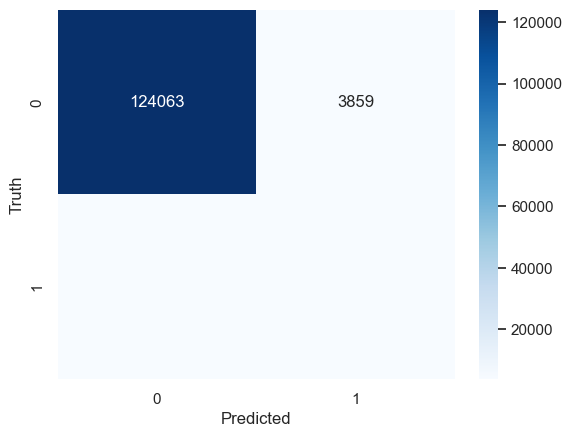

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(target, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [61]:
cm

array([[124063,   3859],
       [  3723,   3843]], dtype=int64)

In [65]:
## Precision recal

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(target, y_train_pred, average='binary') # Use 'micro', 'macro', 'weighted' for multi-class
recall = recall_score(target, y_train_pred, average='binary') # Same as above
f1 = f1_score(target, y_train_pred, average='binary') # Same as above
print(precision, recall, f1)

0.4989613087509738 0.5079302141157811 0.5034058160859314


### Correct instances and incoreect instances

In [81]:
instance_sample = train_df.copy()

In [82]:
instance_sample['correct'] = target == y_train_pred

In [83]:
instance_sample['target'] =target

In [87]:
instance_sample[(instance_sample['correct'] == True) & (instance_sample['target'] == 1)].head(3).to_csv('correct_1.csv',index=False)
instance_sample[(instance_sample['correct'] == False) & (instance_sample['target'] == 1)].head(3).to_csv('false_1.csv',index=False)
instance_sample[(instance_sample['correct'] == True) & (instance_sample['target'] == 0)].head(3).to_csv('true_0.csv',index=False)
instance_sample[(instance_sample['correct'] == False) & (instance_sample['target'] == 0)].head(3).to_csv('false_0.csv',index=False)


### AUC

In [53]:
from sklearn.metrics import roc_curve,auc
y_train_pred = cross_val_predict(pipeline, train_df, target, cv=3, method='predict_proba')




0:	total: 286ms	remaining: 4m 45s
1:	total: 557ms	remaining: 4m 37s
2:	total: 818ms	remaining: 4m 31s
3:	total: 1.05s	remaining: 4m 22s
4:	total: 1.49s	remaining: 4m 57s
5:	total: 1.68s	remaining: 4m 37s
6:	total: 1.82s	remaining: 4m 18s
7:	total: 1.93s	remaining: 3m 59s
8:	total: 2.06s	remaining: 3m 47s
9:	total: 2.2s	remaining: 3m 37s
10:	total: 2.31s	remaining: 3m 27s
11:	total: 2.44s	remaining: 3m 20s
12:	total: 2.55s	remaining: 3m 13s
13:	total: 2.67s	remaining: 3m 8s
14:	total: 2.8s	remaining: 3m 3s
15:	total: 3.08s	remaining: 3m 9s
16:	total: 3.2s	remaining: 3m 4s
17:	total: 3.44s	remaining: 3m 7s
18:	total: 3.91s	remaining: 3m 21s
19:	total: 4.25s	remaining: 3m 28s
20:	total: 4.49s	remaining: 3m 29s
21:	total: 4.74s	remaining: 3m 30s
22:	total: 5.03s	remaining: 3m 33s
23:	total: 5.26s	remaining: 3m 33s
24:	total: 5.43s	remaining: 3m 31s
25:	total: 5.66s	remaining: 3m 31s
26:	total: 5.86s	remaining: 3m 31s
27:	total: 6.02s	remaining: 3m 29s
28:	total: 6.2s	remaining: 3m 27s
29:	

ValueError: y should be a 1d array, got an array of shape (135488, 2) instead.

In [56]:
y_scores = y_train_pred[:, 1]  # Assuming your positive class is at index 1

fpr, tpr, thresholds = roc_curve(target, y_scores)


roc_auc = auc(fpr, tpr)

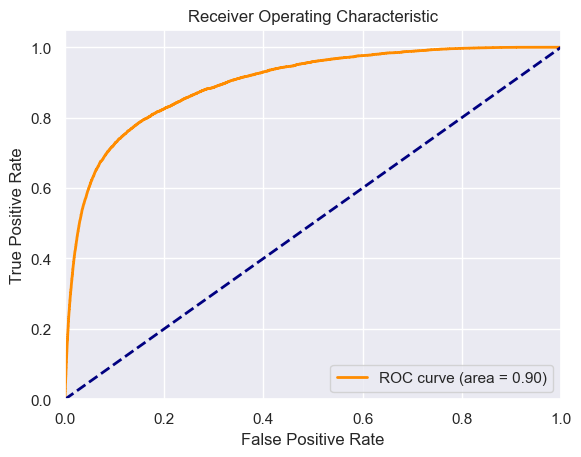

In [57]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Feature importance

In [88]:


# Access the fitted classifiers from the pipeline
# fitted_rf = pipeline.named_steps['voting'].named_estimators_['rf']
# fitted_cat = pipeline.named_steps['voting'].named_estimators_['cat']
fitted_lgbm = pipeline.named_steps['voting'].named_estimators_['lgbm']

# Extract feature importances
# rf_feature_importance = fitted_rf.feature_importances_
# cat_feature_importance = fitted_cat.get_feature_importance()
lgbm_feature_importance = fitted_lgbm.feature_importances_

# If your train_df has column names, you can map these importances to the feature names
feature_names = train_df.columns

# Create a DataFrame to view the feature importances
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    # 'RandomForest': rf_feature_importance,
    # 'CatBoost': cat_feature_importance,
    'LightGBM': lgbm_feature_importance
})


In [89]:
feature_importance_df.to_csv('feature_importance_df.csv',index=False)

## Prediction

In [21]:
test_df

,region_group,creation_day,creation_month,creation_year,duration,disrict_60,disrict_62,disrict_63,disrict_69,client_catg_11,...,Rem_9_GAZ,consumption_diff_sum,consumption_diff_mean,tenure_days,invoice_freq,daily_consumption,first_invoice_gap_ELEC,last_invoice_gap_ELEC,first_invoice_gap_GAZ,last_invoice_gap_GAZ
0,3,28,5,2002,235,0.0,1.0,0.0,0.0,1.0,...,0.0000,4133.0,111.702705,4967,134.20,0.8320,1298.0,6265.0,0.0,0.0
1,2,6,8,2009,148,0.0,0.0,0.0,1.0,1.0,...,0.0000,12732.0,578.727300,3744,170.10,2.5400,-28.0,3716.0,0.0,0.0
2,3,7,4,2004,212,0.0,1.0,0.0,0.0,1.0,...,0.5312,11229.0,151.743240,5022,67.90,2.2360,593.0,5615.0,1842.0,5615.0
3,2,8,10,1992,350,1.0,0.0,0.0,0.0,1.0,...,0.1000,2566.0,64.150000,2486,62.16,1.0320,4595.0,7081.0,4595.0,7081.0
4,3,21,7,1977,533,0.0,1.0,0.0,0.0,1.0,...,0.8335,8349.0,157.528300,5137,96.94,1.6250,10311.0,15448.0,12626.0,15448.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58064,3,17,3,2010,141,0.0,0.0,1.0,0.0,1.0,...,0.0000,461.0,115.250000,88,22.00,5.2400,55.0,143.0,55.0,143.0
58065,3,28,5,2011,127,0.0,0.0,1.0,0.0,1.0,...,0.1305,1963.0,42.673912,3057,66.44,0.6420,23.0,3080.0,23.0,3080.0
58066,2,4,3,1978,525,1.0,0.0,0.0,0.0,1.0,...,0.1364,2616.0,44.338980,5295,89.75,0.4941,9806.0,15101.0,12118.0,15101.0
58067,2,23,2,2018,46,1.0,0.0,0.0,0.0,1.0,...,0.0000,482.0,482.000000,0,0.00,482.0000,60.0,60.0,0.0,0.0


In [72]:
preds = pd.DataFrame(fraud_predictions, columns=['target'])


preds.head()
client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False)
sub_client_id = client_test['client_id']

submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.170289
1,test_Client_1,0.510427
2,test_Client_10,0.041151
3,test_Client_100,0.061203
4,test_Client_1000,0.221673


In [73]:
submission.to_csv(f'{OUTPUT_DIR}/submission_ensemble_on_2.csv', index=False)

### Daphne model

In [56]:
model_dict = {   
                
            
                  'CART': (DecisionTreeClassifier(),
                           {'max_depth': [5,10,100]}),
                           #{'max_depth': [10]}),
              
                  'KNN': (KNeighborsClassifier(),
                          {'n_neighbors': [10,50,100]}),
                          #{'n_neighbors': [10]}),
              
                        
                  'RF': (RandomForestClassifier(),
                         {'n_estimators': [50,100,200,300]})
                         #{'n_estimators': [50]})
             }

In [57]:
results_df = pd.DataFrame(columns=['ROC_AUC'],index=list(model_dict.keys()))
results_df.index.name = 'Model'

In [58]:
for model_name, model_config in model_dict.items():
    print('Model Name：', model_name)
    model = model_config[0]
    parameters = model_config[1]
    
    start_time = time.time()
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)
    clf = GridSearchCV(model, parameters, cv=stkfold, scoring='roc_auc')
    clf.fit(train_df,target)
    
    print('Best Parameter:', clf.best_params_)
    print('Best CV： {:.3f}'.format(clf.best_score_))
    
    results_df.loc[model_name] = [clf.best_score_]
    
    print(f"finished after {time.time() - start_time :.2f} seconds")
    print(' ')
    

Model Name： CART
Best Parameter: {'max_depth': 5}
Best CV： 0.851
finished after 629.62 seconds
 
Model Name： KNN
Best Parameter: {'n_neighbors': 100}
Best CV： 0.762
finished after 736.53 seconds
 
Model Name： RF
Best Parameter: {'n_estimators': 300}
Best CV： 0.881
finished after 8982.88 seconds
 


In [60]:
results_df = results_df.reset_index()

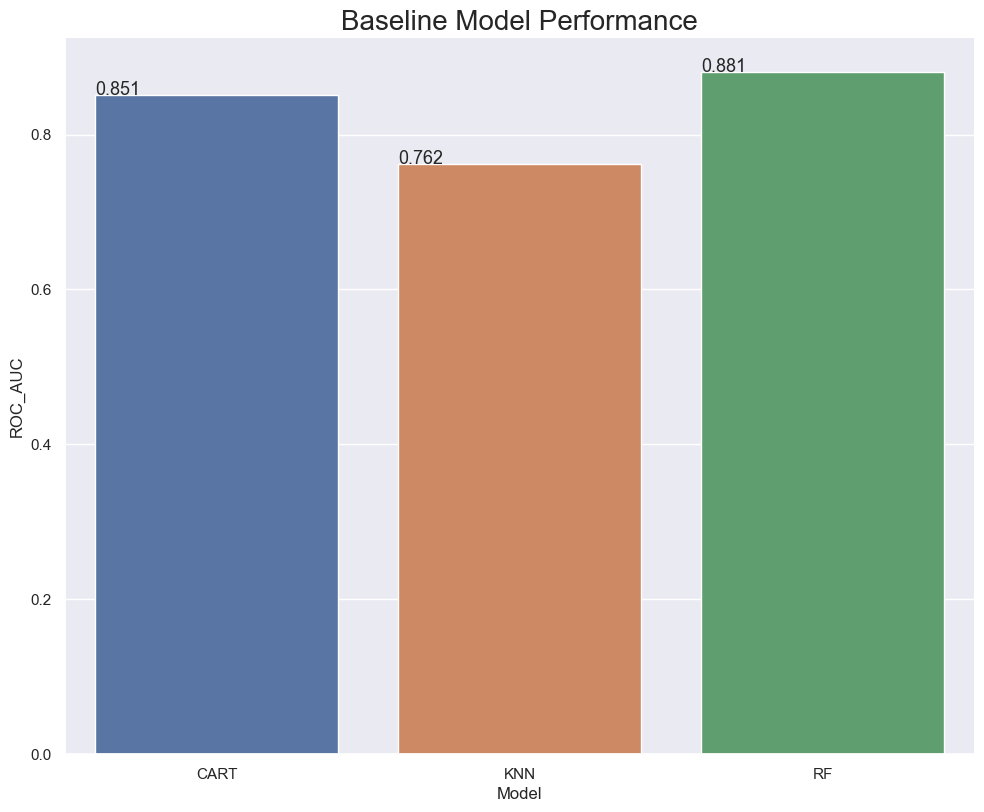

In [61]:
g = sns.catplot(x='Model',y='ROC_AUC',kind='bar',data=results_df,height = 8, aspect = 1.25)
g.ax.set_title(f'Baseline Model Performance',fontsize=20)

for p in g.ax.patches:
    txt = str(p.get_height().round(3))
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt, size=13)

figure = g.fig   
figure.savefig(f'./Model Performance.jpg',format='jpeg',
               dpi=100,
               bbox_inches='tight')